In [1]:
import cv2
import numpy as np
from processing import *
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

## MÉTHODE 1 

In [2]:
SAMPLES = 10 # nombre minimal de points pour former un cluster.
EPS = 3 # distance maximale entre deux points pour les considérer comme dans le même cluster.

In [3]:
# Extraction des données du LiDAR
save_file_name = "./MarcDBScanData/data.pkl"  # Chemin du fichier contenant les données LiDAR
map_file_name = "./MarcDBScanData/su_bigmap.pgm"  # Chemin du fichier image de la carte

# Chargement des données enregistrées
data = load_dico(save_file_name)

# Création d'un tableau d'angles correspondant aux mesures LiDAR
angles = np.linspace(data['angle_min'], data['angle_max'], len(data['ranges']), endpoint=True)

# Extraction des distances mesurées par le LiDAR
distances = data['ranges']

# Position du robot dans le référentiel monde
robot_pos = (data['x'], data['y'], data['z'])

# Orientation du robot en quaternion (x, y, z, w)
robot_orientation = (data['x16'], data['y17'], data['z18'], data['w'])

# Calcul de l'orientation (theta) du robot en radians
theta = calculate_theta(robot_orientation)

# Origine de la carte (coordonnées de l'origine dans le référentiel global)
map_origin = (-4.689781, -1.152219, 0.000000)

# Chargement de l'image de la carte pour déterminer ses dimensions en pixels
map_image = cv2.imread(map_file_name, cv2.IMREAD_GRAYSCALE)
map_height, map_width = map_image.shape

map_resolution = 0.04  # Résolution de la carte (mètres par pixel)
cpm = 1 / map_resolution  # Cellules par mètre

# Calcul des dimensions de la carte en mètres
map_height_meters = map_height * map_resolution
map_width_meters = map_width * map_resolution

# Calcul des dimensions de la grille d'occupation en cellules
grid_height = int(map_height_meters * cpm)  
grid_width = int(map_width_meters * cpm)  

# Conversion des données du LiDAR en une grille d'occupation
occupancy_grid, robot_pos_in_grid, lidar_vect = lidar_to_grid(
    angles, distances, grid_height, grid_width, robot_pos, cpm
)

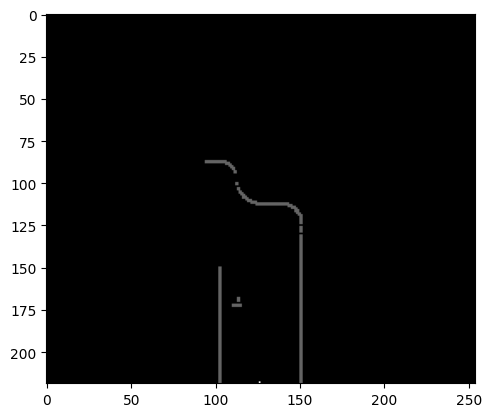

In [4]:
occ_with_car = np.copy(occupancy_grid)

# Marquage de la position du robot dans la grille d'occupation
occ_with_car[robot_pos_in_grid] = 255

# Affichage de la grille d'occupation avec la position du robot
plt.imshow(occ_with_car, cmap='gray')
plt.show()

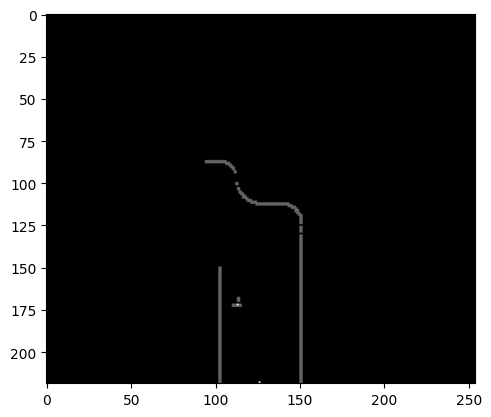

In [5]:
# Détection des obstacles dans la grille d'occupation
clusters = detect_clusters(occupancy_grid)  # Identification des clusters d'obstacles à l'aide de la fonction detect_clusters

# Parcours de chaque obstacle détecté (clusters contient les positions des obstacles)
for obstacle in clusters:
    # Marquage de chaque obstacle sur la grille copiée (occ_with_car)
    occ_with_car[obstacle[0], obstacle[1]] = 255

# Affichage de la grille d'occupation avec la position du robot et des obstacles détectés
plt.imshow(occ_with_car, cmap='gray')
plt.show()

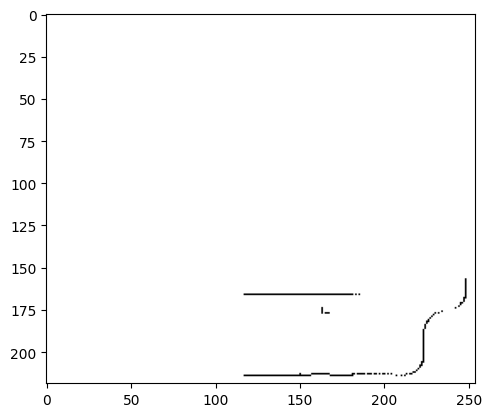

In [6]:
# Création d'une copie de la carte initialisée à des valeurs de 1 (fond clair)
map_image_c = np.ones_like(map_image)

# Parcours de chaque point LIDAR (coordonnées relatives au robot)
for x_lidar, y_lidar in zip(lidar_vect[0], lidar_vect[1]):
    # Conversion des coordonnées LIDAR relatives au robot en coordonnées globales (référentiel monde)
    x_world, y_world = rel_to_world(x_lidar, y_lidar, theta, robot_pos)

    # Prédiction de la position dans le référentiel monde
    predict_pos = (x_world, y_world)

    # Transformation des coordonnées globales en coordonnées de la grille de la carte
    pos_map = world_to_map_grid(map_origin, predict_pos, map_height, map_resolution)

    # Les pixels correspondants aux points LIDAR sont marqués avec la valeur 0 (couleur sombre)
    map_image_c[pos_map] = 0

# Affichage de la carte mise à jour avec les points LIDAR
plt.imshow(map_image_c, cmap='gray')
plt.show()

Cluster en coordonnées relatives au robot : (1.84, 0.52)
Cluster en coordonnées monde : ((1.8259259607319571, 0.5442477467270157))


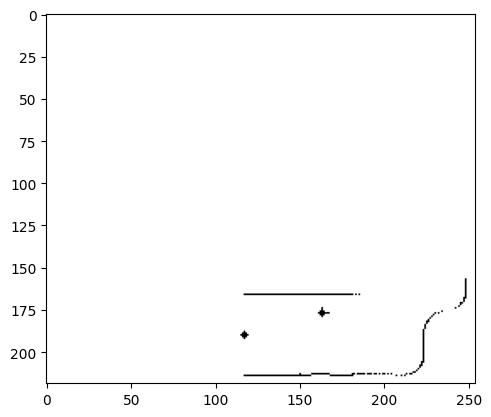

In [7]:
map_image_cp = np.copy(map_image_c)
for cluster in clusters:
    # Conversion des coordonnées du cluster en coordonnées relatives au robot
    x_rel, y_rel = grid_to_rel(cluster, CELLS_PER_METER, occupancy_grid.shape)
    print(f"Cluster en coordonnées relatives au robot : ({x_rel}, {y_rel})")
    
    # Conversion des coordonnées relatives au robot en coordonnées monde (référentiel monde)
    x_world, y_world = rel_to_world(x_rel, y_rel, theta, robot_pos)
    predict_pos = (x_world, y_world)
    print(f"Cluster en coordonnées monde : ({predict_pos})")
    
    # Position du robot sur la carte
    bot_pos_map = world_to_map_grid(map_origin, robot_pos, map_height, map_resolution)  
    # Position de l'obstacle sur la carte
    obs_pos_map = world_to_map_grid(map_origin, predict_pos, map_height, map_resolution) 
    
    # Ajout d'un cercle représentant le cluster (obstacle et le robot) # Cercle noir pour le cluster
    cv2.circle(map_image_c, (obs_pos_map[1], obs_pos_map[0]), 2, (0, 0, 0), -1)
    cv2.circle(map_image_c, (bot_pos_map[1], bot_pos_map[0]), 2, (0, 0, 0), -1)

# Affichage de la carte mise à jour
plt.imshow(map_image_c, cmap='gray')
plt.show()

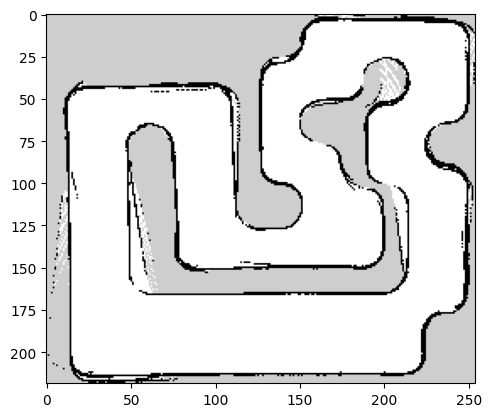

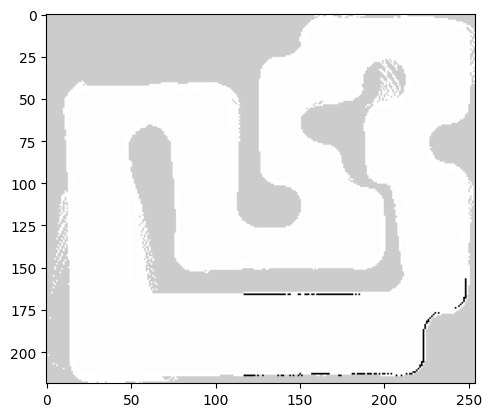

In [8]:
# Affichage de la carte originale (SLAM)
plt.imshow(map_image, cmap='gray')
plt.show()
# Calcul de la différence entre la carte originale et la carte modifiée
difference_map = abs((map_image - map_image_c) / 2)
# Affichage de la carte des différences
plt.imshow(difference_map, cmap='gray')
plt.show()


## MÉTHODE 2 SANS GRID OCCUPANCY

In [9]:
lidar_points = np.stack((lidar_vect[0], lidar_vect[1]), axis=1)
clustering = DBSCAN(eps=EPS/cpm, min_samples=SAMPLES).fit(lidar_points)

In [10]:
labels = clustering.labels_
cluster_centers = []
# Parcours de chaque étiquette de cluster
for label in set(labels):
    if label != -1:  # Ignore le bruit
        # Filtre les points appartenant au cluster actuel
        cluster_points = lidar_points[labels == label]
        if 0 < len(cluster_points) < 30:
            # Calcule le centre de l'obstacle
            center_x = np.mean(cluster_points[:, 0])
            center_y = np.mean(cluster_points[:, 1])
            cluster_centers.append((center_x, center_y))
            print(f"Centre de l'obstacle {(center_x, center_y)}")

Centre de l'obstacle (np.float64(1.8679705389955772), np.float64(0.5549240819181459))


Cluster en coordonnées monde : ((np.float64(1.8537036142279866), np.float64(0.5793254392934173)))


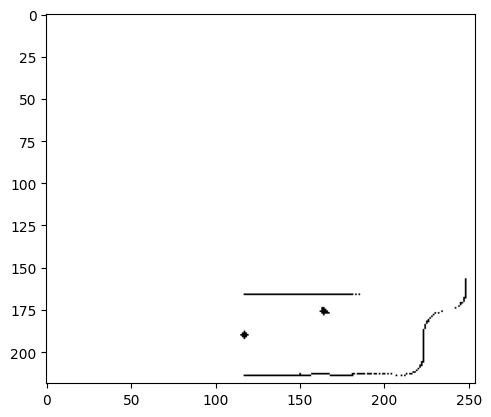

In [11]:
for cluster_center in cluster_centers:    
    # Conversion des coordonnées relatives au robot en coordonnées monde (référentiel monde)
    x_world, y_world = rel_to_world(cluster_center[0], cluster_center[1], theta, robot_pos)
    predict_pos = (x_world, y_world)
    print(f"Cluster en coordonnées monde : ({predict_pos})")
    
    # Position du robot sur la carte
    bot_pos_map = world_to_map_grid(map_origin, robot_pos, map_height, map_resolution)  
    # Position de l'obstacle sur la carte
    obs_pos_map = world_to_map_grid(map_origin, predict_pos, map_height, map_resolution) 
    
    # Ajout d'un cercle représentant le cluster (obstacle et le robot) # Cercle noir pour le cluster
    cv2.circle(map_image_cp, (obs_pos_map[1], obs_pos_map[0]), 2, (0, 0, 0), -1)
    cv2.circle(map_image_cp, (bot_pos_map[1], bot_pos_map[0]), 2, (0, 0, 0), -1)

# Affichage de la carte mise à jour
plt.imshow(map_image_cp, cmap='gray')
plt.show()